LangGraph 节点与可控制性

- 基本控制：串行控制  
- 基本控制：分支控制  
- 基本控制：条件与循环  
- 精细控制：图的运行时配置  
- 精细控制：map-reduce

In [1]:
# 安装依赖
!pip install -U langgraph

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Attempting uninstall: langgraph-sdk
    Found existing installation: langgraph-sdk 0.2.8
    Uninstalling langgraph-sdk-0.2.8:
      Successfully uninstalled langgraph-sdk-0.2.8
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.76
    Uninstalling langchain-core-0.3.76:
      Successfully uninstalled langchain-core-0.3.76
  Attempting uninstall: langgraph-prebuiltm━━━━━━━━━━━━━━━━━━━━━━━ 2/5 [langchain-core]
    Found existing installation: langgraph-prebuilt 0.6.4━━━━━ 2/5 [langchain-core]
    Uninstalling langgraph-prebuilt-0.6.4:━━━━━━━━━━━━━━━━━━━━ 2/5 [langchain-core]
      Successfully uninstalled langgraph-prebuilt-0.6.4━━━━━━━ 2/5 [langchain-core]
  Attempting uninstall: langgraph╺━━━━━━━━━━━━━━━ 3/5 [langgraph-prebuilt]
    Found existing installation: langgraph 0.6.7━━━━━━━━━━━━━━ 3/5 [langgraph-prebuilt]
    Uninstalling langgraph-0.6.7:╺━━━━━━━━━━━━━━━ 3/5 [langgraph-preb

### LangGraph简单使用

定义stahe(节点和节点之间的控制流)

实现方式：
+ TypedDict：属于Python标准库typing模块的一部分，仅提供静态类型检查，运行时不执行验证  
+ Pydantic：第三方库，需要单独安装，提供运行时数据验证和序列化功能

In [2]:
# 定义stahe(节点和节点之间的控制流)
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


# 定义节点间通讯的消息格式
class State(TypedDict):
    messages: list[TypedDict]
    extra_field: int

In [3]:
# 定义节点
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("你好！我是节点1")

    return {"messages": messages + [new_message], "extra_field": 1}

In [ ]:
# 创建图（包含一个节点使用state通讯）
from langgraph.graph import StateGraph

graph = StateGraph(State)
# 添加节点
graph.add_node(node)
# 设置入口
graph.set_entry_point("node")
# 执行编译
graph_builder = graph.compile()

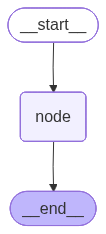

In [7]:
# 查看节点与图结构
# Mermaid 是一种基于文本的图表和可视化工具，它允许用户通过简单的文本语法来创建复杂的图标和流程图。

from IPython.display import Image, display

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [ ]:
# 调用
from langchain_core.messages import HumanMessage

result = graph_builder.invoke({"messages": [HumanMessage("你好，我是tomie")]})

result

{'messages': [HumanMessage(content='你好，我是tomie', additional_kwargs={}, response_metadata={}),
  AIMessage(content='你好！我是节点1', additional_kwargs={}, response_metadata={})],
 'extra_field': 1}

In [ ]:
# 使用pretty_print来格式化显示
from langchain_core.messages import HumanMessage

result = graph_builder.invoke({"messages": [HumanMessage("你好，我是tomie")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

你好，我是tomie
================================== Ai Message ==================================

你好！我是节点1


### 基本控制：串行控制  

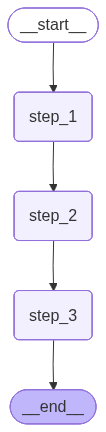

In [14]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph


class State(TypedDict):
    value_1: str
    value_2: str


# 定义节点
def step_1(state: State):
    return {"value_1": "a"}


def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1}+b"}


def step_3(state: State):
    return {"value_2": "10"}


# 使用图把节点组织起来
graph_builder = StateGraph(State)
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")
graph_builder.add_edge("step_3", END)


# 将图编译
graph = graph_builder.compile()

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# 使用图

graph.invoke({"value_1": "c"})

{'value_1': 'a+b', 'value_2': '10'}

### 基本控制：分支控制  

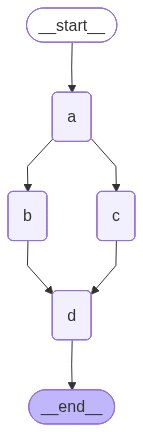

In [16]:
import operator
from typing import Any, Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph


# Annotated 允许为类型提供额外的元数据，而不是影响类型检查器对类型本身的理解
class State(TypedDict):
    aggregate: Annotated[list, operator.add]


# 定义节点
def a(state: State):
    print(f"添加A到{state['aggregate']}")
    return {"aggregate": ["A"]}


def b(state: State):
    print(f"添加B到{state['aggregate']}")
    return {"aggregate": ["B"]}


def c(state: State):
    print(f"添加C到{state['aggregate']}")
    return {"aggregate": ["C"]}


def d(state: State):
    print(f"添加D到{state['aggregate']}")
    return {"aggregate": ["D"]}


# 使用图把节点组织起来
graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "a")
graph_builder.add_edge("a", "b")
graph_builder.add_edge("a", "c")
graph_builder.add_edge("b", "d")
graph_builder.add_edge("c", "d")
graph_builder.add_edge("d", END)

# 将图编译
graph = graph_builder.compile()

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 使用图

graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

添加A到[]
添加B到['A']
添加C到['A']
添加D到['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

### 基本控制：条件与循环  

#### 条件边

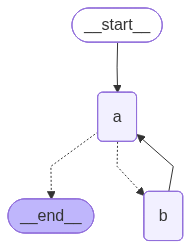

In [18]:
import operator
from typing import Any, Annotated, Literal
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph


# Annotated 允许为类型提供额外的元数据，而不是影响类型检查器对类型本身的理解
class State(TypedDict):
    aggregate: Annotated[list, operator.add]


# 定义节点
def a(state: State):
    print(f"添加A到{state['aggregate']}")
    return {"aggregate": ["A"]}


def b(state: State):
    print(f"添加B到{state['aggregate']}")
    return {"aggregate": ["B"]}


# 使用图把节点组织起来
graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)


def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)  # 条件边
graph_builder.add_edge("b", "a")

# 将图编译
graph = graph_builder.compile()

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 调用

graph.invoke({"aggregate": []})

添加A到[]
添加B到['A']
添加A到['A', 'B']
添加B到['A', 'B', 'A']
添加A到['A', 'B', 'A', 'B']
添加B到['A', 'B', 'A', 'B', 'A']
添加A到['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

In [20]:
# 使用递归限制recursion_limit来防止异常情况下的大量无用调用
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

添加A到[]
添加B到['A']
添加A到['A', 'B']
添加B到['A', 'B', 'A']
Recursion Error


#### 循环边

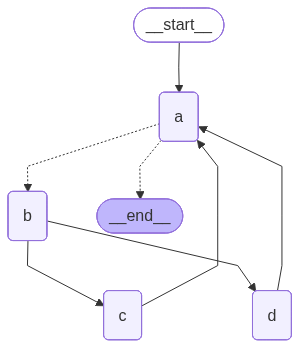

In [ ]:
import operator
from typing import Any, Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph


# Annotated 允许为类型提供额外的元数据，而不是影响类型检查器对类型本身的理解
class State(TypedDict):
    aggregate: Annotated[list, operator.add]


# 定义节点
def a(state: State):
    print(f"添加A到{state['aggregate']}")
    return {"aggregate": ["A"]}


def b(state: State):
    print(f"添加B到{state['aggregate']}")
    return {"aggregate": ["B"]}


def c(state: State):
    print(f"添加C到{state['aggregate']}")
    return {"aggregate": ["C"]}


def d(state: State):
    print(f"添加D到{state['aggregate']}")
    return {"aggregate": ["D"]}


# 使用图把节点组织起来
graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)


def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "c")
graph_builder.add_edge("b", "d")
graph_builder.add_edge(["c", "d"], "a")


# 将图编译
graph = graph_builder.compile()

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 调用

graph.invoke({"aggregate": []})

添加A到[]
添加B到['A']
添加C到['A', 'B']
添加D到['A', 'B']
添加A到['A', 'B', 'C', 'D']
添加B到['A', 'B', 'C', 'D', 'A']
添加C到['A', 'B', 'C', 'D', 'A', 'B']
添加D到['A', 'B', 'C', 'D', 'A', 'B']
添加A到['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


{'aggregate': ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D', 'A']}

### 精细控制：图的运行时配置  

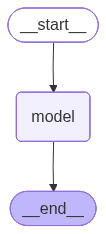

In [39]:
import os
import operator
from typing import Any, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_deepseek import ChatDeepSeek
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables.config import RunnableConfig
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv


load_dotenv(".env", override=True)

model_1 = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)


model_2 = ChatOpenAI(
    openai_api_base=os.getenv("OPENAPI_API_BASE"),
    openai_api_key=os.getenv("OPENAPI_API_KEY"),
    model=os.getenv("OPENAPI_MODEL"),
    temperature=0,
)

# 定义要切换的模型
models = {"deepseek": model_1, "openai": model_2}


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


# 构建节点
def _call_model(state: AgentState, config: RunnableConfig):
    # 使用LCEL的配置
    model_name = config["configurable"].get("model", "deepseek")
    model = models[model_name]
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# 使用图把节点组织起来
graph_builder = StateGraph(AgentState)
graph_builder.add_node("model", _call_model)


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "model")
graph_builder.add_edge("model", END)

# 将图编译
graph = graph_builder.compile()

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# 调用

# 没有增加运行时配置时，默认使用deepseek
graph.invoke({"messages": [HumanMessage(content="你是谁？")]})

{'messages': [HumanMessage(content='你是谁？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='你好！我是DeepSeek，由深度求索公司创造的AI助手！😊\n\n我是一个纯文本模型，虽然不支持多模态识别功能，但我有文件上传功能，可以帮你处理图像、txt、pdf、ppt、word、excel等文件，从中读取文字信息进行分析处理。我完全免费使用，拥有128K的上下文长度，还支持联网搜索功能（需要你在Web/App中手动点开联网搜索按键）。\n\n你可以通过官方应用商店下载我的App来使用。我很乐意为你解答问题、协助处理文档、进行对话交流等等！\n\n有什么我可以帮助你的吗？无论是学习、工作还是日常问题，我都很愿意为你提供帮助！✨', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_tokens': 6, 'total_tokens': 147, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 6}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5298717f-c118-4239-8e7b-1655d6db9ea8', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b6cc8-c454-7d71-8fc5-8d3a49de5d78-0', usage_metadata={'input_tokens': 6, 'output_tokens': 141, '

In [ ]:
# 增加运行时配置，动态切换模型
config = {"configurable": {"model": "openai"}}
graph.invoke({"messages": [HumanMessage(content="你是谁？")]}, config=config)

{'messages': [HumanMessage(content='你是谁？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='你好！我是DeepSeek，由深度求索公司创造的AI助手！😊\n\n我是一个纯文本模型，虽然不支持多模态识别功能，但我有文件上传功能，可以帮你处理图像、txt、pdf、ppt、word、excel等文件，从中读取文字信息进行分析处理。我完全免费使用，拥有128K的上下文长度，还支持联网搜索功能（需要你在Web/App中手动点开联网搜索按键）。\n\n你可以通过官方应用商店下载我的App来使用我。我很乐意帮助你解答问题、处理文档、进行对话交流等等！\n\n有什么我可以帮助你的吗？无论是学习、工作还是日常问题，我都很愿意为你提供帮助！✨', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_tokens': 6, 'total_tokens': 147, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 6}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'd8dae58d-33c8-4fad-9ffe-46d68058b9de', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b6cca-bd7f-7e41-90bc-76587b191391-0', usage_metadata={'input_tokens': 6, 'output_tokens': 141, '

### 精细控制：map-reduce并行执行

给定一个来自用户的一般主题，生成相关主题列表，为每个主题生成一个笑话，并从结果列表中选择最佳笑话。

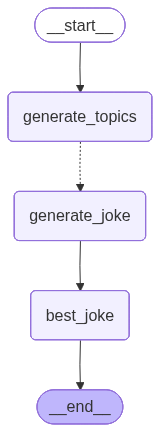

In [49]:
import os
import operator
from typing import Any, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_deepseek import ChatDeepSeek
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables.config import RunnableConfig
from IPython.display import Image, display
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from pydantic import BaseModel, Field
from dotenv import load_dotenv


load_dotenv(".env")

# 提示词定义
subjects_prompt = """生成一个逗号分隔的列表，包含 3 到 5 个具体的、互不相同的子话题。
直接返回结果，不要解释。：{topic}"""
joke_prompt = """生成一个关于{subject}的笑话"""
best_joke_prompt = """以下是一些关于{topic}的笑话。选出最好的一个，返回最佳笑话的ID

{jokes}
"""


# 定义数据模型
class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int = Field(description="最佳笑话的索引。从0开始", ge=0)


model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)


# 图之间流动的数据结构
# 这是主图的整体状态，包含一个主题，然后根据这个主题生成一个主题列表，并为每个主题生成一个笑话
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


class JokeState(TypedDict):
    subject: str


# 定义节点
def generate_topics(state: OverallState):
    # 生成笑话主题
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


def generate_joke(state: OverallState):
    # 根据主题生成笑话
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


def continue_to_jokes(state: OverallState):
    """
    动态分发逻辑
    使用了 LangGraph 的 Send 机制，返回一个Send对象列表
    每个Send对象包含图中节点的名称
    以及要发送到该节点的状态
    """
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


def best_joke(state: OverallState):
    # 评判最佳笑话
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# 使用图把节点组织起来
graph_builder = StateGraph(OverallState)
graph_builder.add_node("generate_topics", generate_topics)
graph_builder.add_node("generate_joke", generate_joke)
graph_builder.add_node("best_joke", best_joke)


# 设置节点之间的关系（箭头）
graph_builder.add_edge(START, "generate_topics")
graph_builder.add_conditional_edges(
    "generate_topics", continue_to_jokes, ["generate_joke"]
)
graph_builder.add_edge("generate_joke", "best_joke")
graph_builder.add_edge("best_joke", END)

# 将图编译
graph = graph_builder.compile()

# 显示图的关系
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
# 调用

for s in graph.stream({"topic": "动物"}):
    print(s)

{'generate_topics': {'subjects': ['哺乳动物', '鸟类', '爬行动物', '鱼类', '昆虫']}}
{'generate_joke': {'jokes': ['为什么蜜蜂总是嗡嗡叫？因为它们不会吹口哨！']}}
{'generate_joke': {'jokes': ['为什么鱼不喜欢玩扑克牌？因为当它们看到河牌时，总是会紧张得流汗！']}}
{'generate_joke': {'jokes': ['为什么鳄鱼不去参加派对？因为它总是穿着同样的旧皮衣！']}}
{'generate_joke': {'jokes': ['为什么哺乳动物不喜欢玩扑克牌？因为每次有人喊"哺乳动物！"它们都会以为是在叫自己！']}}
{'generate_joke': {'jokes': ['为什么鸟儿不喜欢玩扑克牌？因为当它们看到老鹰时，总是会"鹰"（应）声而逃！']}}
{'best_joke': {'best_selected_joke': '为什么哺乳动物不喜欢玩扑克牌？因为每次有人喊"哺乳动物！"它们都会以为是在叫自己！'}}
